In [9]:
#working document uses the data used by Nicholas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.interpolate import interp1d

In [2]:
#Inputting and modelling the data

def input_spectra(gasname, filepath, isheader, separation, wavelengthunits, wavelengthcol, datacol):
    """
    This function input_spectra loads in the datafile for the spectral information and assigns values to the wavelength and spectral data.
    
    Parameters include:
        - gasname         : user inputs the name of the gas 
        - filepath        : input file with at least one column for wavelength given in nanometers (nm) or micrometres (um)
                            and one column for spectral line intensity. Needs to be contained within "".  
        - isheader        : parameter takes in whether there is a header in the file. None means there is no header present
        - separation      : parameter takes in what the separation between the variables within the file
                            e.g. "\t" means values separated by a tab
        - wavelengthunits : enter the units of the wavelength data, input "um" or "nm", function will convert units into um. 
        - wavelengthcol   : user inputs which column consists of the wavelength values
        - datacol         : user inputs which column consists of the spectra data values
    """

    #Inputs the data file
    gas_raw_data = pd.read_csv(filepath, header = isheader, sep = separation).values #stores the file into a variable 
    gas_wavelength = (gas_raw_data[:,wavelengthcol]).astype(float) #variable stores the wavelength range
    gas_absorption_line_data = (gas_raw_data[:,datacol]).astype(float) #variable stores the absorption line data for each line 
    
    if wavelengthunits == "um":
        gas_wavelength = gas_wavelength #leaves the wavelength units in micrometres (um)
    elif wavelengthunits == "nm": 
        gas_wavelength = (gas_wavelength/1000.0) #converts the wavelength units into micrometres (um)
    else:
        print("Please input the wavelength as um or nm")
    
    #Modelling the absorption lines as a Lorentzian
    

    return gasname, gas_wavelength, gas_absorption_line_data

In [3]:
#Testing function using Nicholas' data (Sail Labs?!)
gasname, spectra_wav, spectra_data = input_spectra('acetylene', '/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/C2H2 gas cell-_40nm_1_T_C33-c2h2200C3M_42nm_0_T.txt', None, '\t', 'nm', 0, 2)

#Testing function using own data (NASA PSG)
#gasname, spectra_wav, spectra_data = input_spectra('acetylene_nasa', '/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/New Code/psg_trn.txt', None, ' ', 'um', 0, 2)


In [4]:
# Function plots spectra for a given file 

def plot_spectra(gasname, spectra_wav, spectra_data):
   """
   This function provides a plotting facility for the input gas data file. 

   The parameters include: 
      - gasname         : input requires the name of the gas
      - spectra_wav     : loads in the wavelengths 
      - spectra_data    : loads in the spectral data  
   """

   gas_wavelength = spectra_wav
   gas_absorption_line_data = spectra_data

   figure(figsize=(15, 4))
   plt.plot(gas_wavelength, gas_absorption_line_data)
   plt.title('Absorption spectrum of' + ' ' + gasname + ' ' + 'gas')
   plt.xlabel('Wavelength (um)')
   plt.ylabel('Tx (dB) - assuming units are correct!')
   plt.show()
   
   return

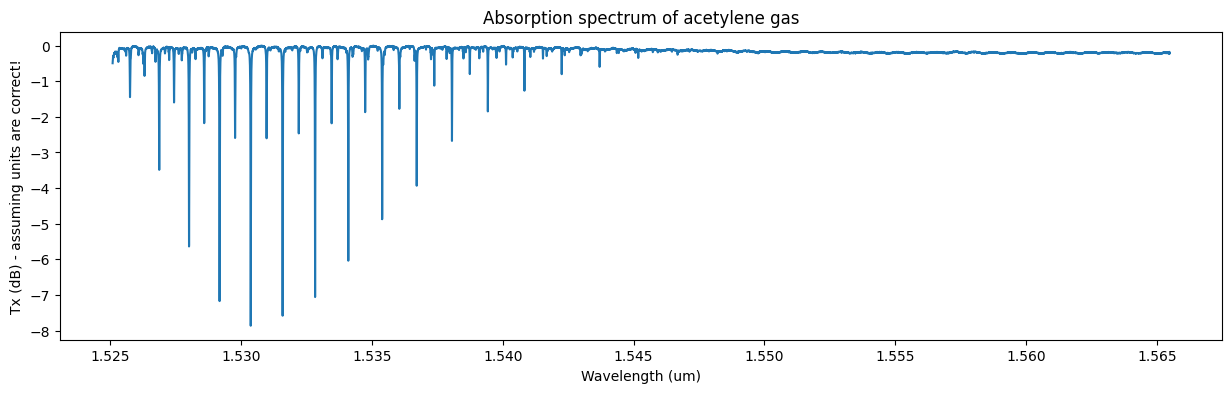

In [5]:
#Testing plot function
plot_spectra(gasname, spectra_wav, spectra_data)

In [6]:
# Inputting the blackbody

def blackbody_spectrum(wavelength, temp, plot):
    """
    BlackBody Spectrum to model broadband light source and simulate the absorption of the gas. 
    Blackbody assumes input units to be in Hertz and the output scale will be assumed to be in (erg / (cm^2 * s * Hz * sr). 

     The parameters include: 
      - wavelength      : inputs the wavelength
      - temp            : inputs the temperature of the blackbody
      - plot            : requires 'yes' or 'no' input for a plot
    """
    #f = interp1d(spectra_wav, spectra_data, fill_value = "extrapolate")
    #new_wav = np.linspace(min(spectra_wav), max(spectra_wav)) #adding more values of the wavelength at equal intervals 
    #new_data_values = f(new_wav)
    #frac_abs_gas = 10**(new_data_values/10) #converting from dB to fractional absorption
    
    frac_abs_gas = 10**(spectra_data/10) #converting from dB to fractional absorption

    bb = BlackBody(temperature = temp*u.K) #scale = ((10**-6)*u.J) / (u.cm**2 * u.nm * u.s * u.sr)) #(!!!)
    
    wavelength_units = (spectra_wav*u.um) #does this convert or attach units onto the values?
    flux = bb(wavelength_units)

    bb_absorbed_flux = flux*frac_abs_gas

    if plot == 'yes': 
      figure(figsize=(15, 4))
      plt.plot(wavelength_units, bb_absorbed_flux)
      plt.title('Blackbody spectrum with absorbed' + ' ' + gasname + ' ' + 'gas')
      plt.xlabel('Wavelength (um)')
      plt.ylabel('Tx (dB) - assuming units are correct!')
      plt.show()
    elif plot == 'no': 
      print('No visualisation')
    else: 
      print("Please input 'yes' or 'no' if you would like a plot of the spectrum")

    return bb_absorbed_flux

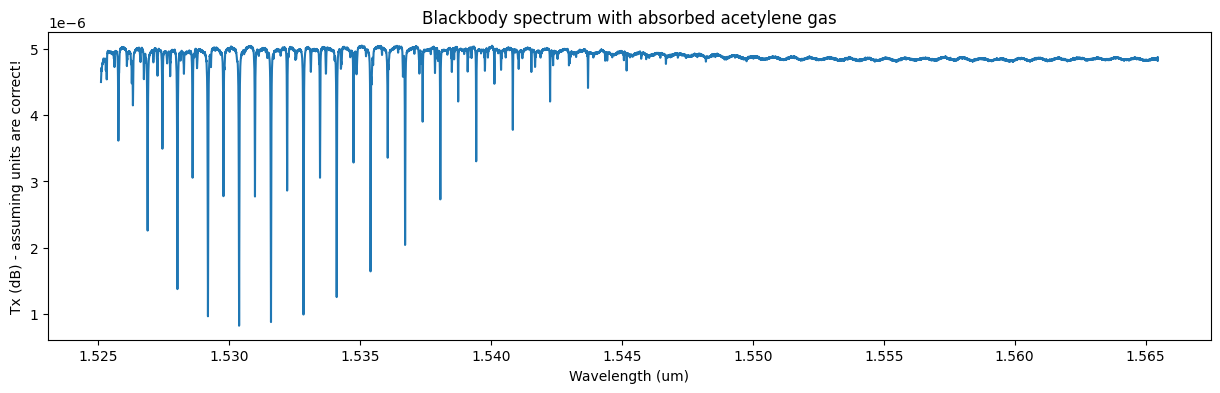

In [7]:
#Testing blackbody function --- looks same as Nicholas' but y axis differs
bb_absorbed_flux = blackbody_spectrum(spectra_wav, 3000, 'yes')

In [10]:
#Converting from flux units (J/cm2 nm s sr) to photon counts (photons/nm sec)

def convert_fluxunits_to_photoncounts(wavelength, flux, emission_coefficient, area, solid_angle):
    """

    Parameters: 
        - flux                  : input flux value to be converted into photon counts
        - emisson_coefficient   : requires the emission coefficient of the light source filament at a 
                                  particular temperature 
        - area                  : area of the fibre cross-section (cm^2)
        - solid_angle           : solid angle (steradians) that reaches the fibre core of a particular 
                                  diameter
    """
    tc = emission_coefficient
    A = area
    sr = solid_angle

    photoncount = ((tc*flux*A*sr)*wavelength)/(1e9*const.c*const.h)
    photoncount_value = photoncount.value

    figure(figsize=(15, 4))
    plt.plot(wavelength, photoncount_value)
    plt.title('Photon counts (per nm per sec) for' + ' ' + gasname + ' ' + 'gas')
    plt.xlabel('Wavelength (um)')
    plt.ylabel('Photons / nm sec')
    plt.show()

    return photoncount_value

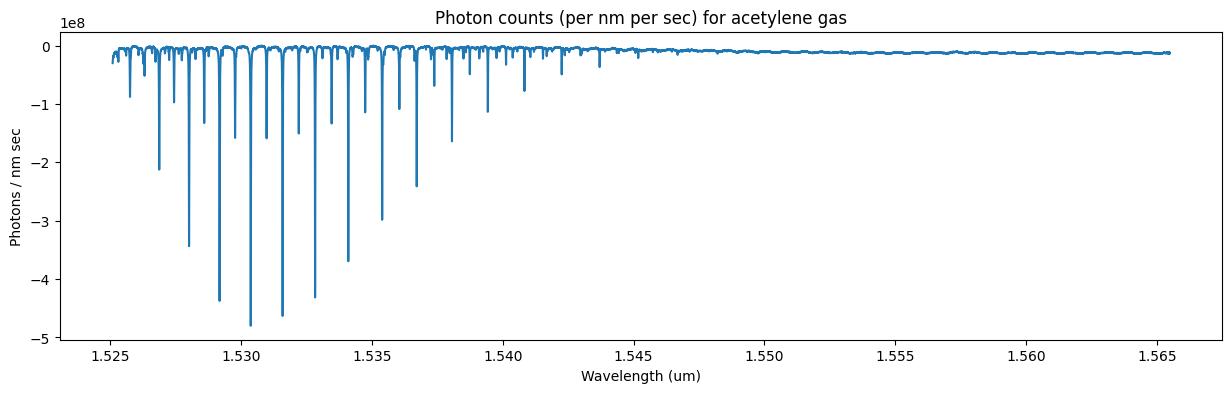

[-30180667.29574801 -27520547.19313449 -28939456.1914645  ...
 -14163392.33570365 -11201220.24487208 -13607792.87193855]


In [11]:
#testing unit conversion function

photoncount_value = convert_fluxunits_to_photoncounts(spectra_wav, spectra_data, 0.35, 0.000000503, 0.045)
print(photoncount_value)

Modelling (in progress)

In [ ]:
#https://specutils.readthedocs.io/en/stable/fitting.html
#https://iopscience.iop.org/article/10.3847/1538-3881/abe12a
#https://pyplatefit.readthedocs.io/en/latest/tutorial.html
#try these ones instead :)

In [ ]:
#https://www.geeksforgeeks.org/python-gaussian-fit/
#https://stackoverflow.com/questions/52502896/how-can-i-fit-a-good-lorentzian-on-python-using-scipy-optimize-curve-fit
#http://emilygraceripka.com/blog/16

from scipy.optimize import leastsq

acetylene = '/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/C2H2 gas cell-_40nm_1_T_C33-c2h2200C3M_42nm_0_T.txt'
C2H2_l_full = pd.read_csv(acetylene,header=None,sep='\t').values
C2H2_wav = (C2H2_l_full[:,0]).astype(float) # wavelength for C2H2 data (nm)
C2H2_spec = (C2H2_l_full[:,2]).astype(float) # spectrum for C2H2 data (dB)

xdata = np.array(C2H2_wav)
ydata = np.array(C2H2_spec) 
  
# Recast xdata and ydata into numpy arrays so we can use their handy features 
xdata = np.asarray(xdata) 
ydata = np.asarray(ydata) 

#define a function i.e. lorentzian
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

counter = 0
generalWidth = 1 
startValues = [ max( ydata ) ]

while max( ydata ) - min( ydata ) > .1:
    counter += 1
    if counter > 20: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmin( ydata )
    minY = ydata[ minP ]
    x0 = xdata[ minP ]
    startValues += [ x0, minY - max( ydata ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xdata, ydata ) )
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xdata, ydata ) ]



In [ ]:
help(curve_fit)